In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
for key in meta:
    if 'badEmoid' in meta[key]:
        print(key)

601983541597


In [9]:
import numpy as np

# Load emoid data

nEmoid = 0

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        nEmoid += 1
        nTs = meta[key]['emoidData'].shape[1]

p_emoid = np.zeros([nEmoid,264,264])
ages = np.zeros([nEmoid])
c = 0

for key in meta:
    if 'emoid' in meta[key] and 'badEmoid' not in meta[key]:
        p_emoid[c] = np.corrcoef(meta[key]['emoidData'])
        ages[c] = meta[key]['meta']['AgeInMonths']/12
        c += 1
    if c % 100 == 0:
        print(f'Finished {c}')
        
print(nEmoid)
print('Complete')

Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
678
Complete


In [6]:
import torch

# Convert to PyTorch

p_emoid_t = torch.from_numpy(p_emoid).float().cuda()
ages_t = torch.from_numpy(ages).float().cuda()

print('Complete')

Complete


In [8]:
# Select a small sample

train_t = p_emoid_t[0:100].reshape(-1,264*264)
test_t = p_emoid_t[100:200].reshape(-1,264*264)
full_t = p_emoid_t[0:200].reshape(-1,264*264)

print('Complete')

Complete


In [35]:
import torch.nn as nn
import torch.nn.functional as F

# Train a regular GCN

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity
def calcEdges(ps1, ps2):
    nB = ps1.shape[0]
    e = torch.einsum('ai,bi->ab',ps1,ps2)
    F1 = torch.einsum('ai,ai->a',ps1,ps1)**0.5
    F2 = torch.einsum('ai,ai->a',ps2,ps2)**0.5
    e /= F1.unsqueeze(1)
    e /= F2.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

Atrain = calcEdges(train_t, train_t) + torch.eye(100).float().cuda()
A = calcEdges(full_t, full_t) + torch.eye(200).float().cuda()

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(264*264,100).float().cuda()
        self.gc2 = nn.Linear(100,1).float().cuda()
        self.loss = nn.MSELoss()

    def forward(self, x):
        A = x[0]
        z = x[1]
        a = A@z
        a = F.relu(self.gc1(a))
        a = A@a
        a = self.gc2(a)
        return a

gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2) # 1e-5 and 0.2

nEpoch = 3000 # 2000 for age pred, 3000 for sex classification, 2000 sex classification GIN
pPrint = 200

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([Atrain,train_t]).flatten()
    loss = gcn.loss(pred, ages_t[:100])
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print(f'Complete GCN')

pred = gcn([A,full_t]).flatten()[100:].detach().cpu().numpy()
mae = np.mean(np.abs(pred-ages[100:200]))

print(f'MAE {mae}')

epoch 0 loss=217.54733276367188
epoch 200 loss=12.835386276245117
epoch 400 loss=6.52755069732666
epoch 600 loss=3.45135498046875
epoch 800 loss=1.9102256298065186
epoch 1000 loss=1.13094162940979
epoch 1200 loss=0.6753607988357544
epoch 1400 loss=0.43953055143356323
epoch 1600 loss=0.310308575630188
epoch 1800 loss=0.21245071291923523
epoch 2000 loss=0.1485190987586975
epoch 2200 loss=0.1100497916340828
epoch 2400 loss=0.08117084950208664
epoch 2600 loss=0.060795072466135025
epoch 2800 loss=0.049869321286678314
epoch 2999 loss=0.043603409081697464
Complete GCN
MAE 2.2975812403361


In [28]:
# Train a contrastive loss network

import torch.nn as nn
import itertools
import random
import copy

class ConGraph(nn.Module):
    def __init__(self):
        super(ConGraph, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,1).float().cuda()
        self.loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cg = ConGraph()
optim = torch.optim.Adam(cg.parameters(), lr=1e-4, weight_decay=0)

nEpoch = 30
bSize = 1000
pPeriod = 2000

pairs = list(itertools.combinations_with_replacement(np.arange(100),2))

for epoch in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {epoch}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A = train_t[Ai,:]
        B = train_t[Bi,:]
        a = ages_t[list(Ai)]
        b = ages_t[list(Bi)]
        optim.zero_grad()
        pos = torch.cat([A,B],dim=1)
        neg = torch.cat([B,A],dim=1)
        pres = cg(pos).flatten()
        nres = cg(neg).flatten()
        pp = pres-(a-b)
        nn = nres-(b-a)
        pLoss = cg.loss(pp, torch.zeros(todo).float().cuda())
        nLoss = cg.loss(nn, torch.zeros(todo).float().cuda())
        (pLoss+nLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0 and epoch % 3 == 0:
            print(f'\tposLoss={pLoss} negLoss={nLoss}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=24.904829025268555 negLoss=24.998981475830078
	posLoss=41.796653747558594 negLoss=47.35601043701172
	posLoss=26.28200912475586 negLoss=24.599939346313477
epoch 1
epoch 2
epoch 3
	posLoss=18.927078247070312 negLoss=18.26167869567871
	posLoss=18.19991683959961 negLoss=20.374223709106445
	posLoss=17.402238845825195 negLoss=17.952987670898438
epoch 4
epoch 5
epoch 6
	posLoss=15.886873245239258 negLoss=14.606696128845215
	posLoss=13.91581916809082 negLoss=13.725851058959961
	posLoss=13.906124114990234 negLoss=13.950984954833984
epoch 7
epoch 8
epoch 9
	posLoss=9.4705171585083 negLoss=9.64574146270752
	posLoss=8.714994430541992 negLoss=8.38137149810791
	posLoss=9.107583045959473 negLoss=9.007559776306152
epoch 10
epoch 11
epoch 12
	posLoss=5.858794689178467 negLoss=5.835433006286621
	posLoss=5.342374324798584 negLoss=5.204936981201172
	posLoss=5.1748223304748535 negLoss=5.063051223754883
epoch 13
epoch 14
epoch 15
	posLoss=3.1500959396362305 negLoss=3.0236446857452393
	posLo

In [37]:
wp = np.zeros(100)
wn = np.zeros(100)

for i in range(100):
    if i % 20 == 0:
        print(f'done {i}')
        
    A = test_t[i].expand(100,-1)

    B = train_t
    b = ages_t[:100]

    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    pres = cg(pos).flatten()
    nres = cg(neg).flatten()

    wp[i] = torch.mean(pres + b).detach().cpu().numpy()
    wn[i] = torch.mean(b - nres).detach().cpu().numpy()
    
print('Complete')

done 0
done 20
done 40
done 60
done 80
Complete


In [38]:
print(np.mean(np.abs(wp-ages[100:200])))
print(np.mean(np.abs(wn-ages[100:200])))

2.1649199231465657
2.159523588816325


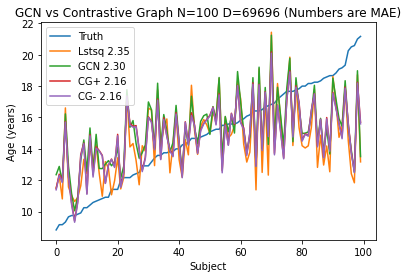

In [42]:
import matplotlib.pyplot as plt

tgt = ages[100:200]
idcs = np.argsort(tgt)
tgt = tgt[idcs]
pred2 = pred[idcs]
lsqPred2 = lsqPred[idcs]
wp2 = wp[idcs]
wn2 = wn[idcs]

plt.plot(tgt, label='Truth')
plt.plot(lsqPred2.detach().cpu().numpy(), label='Lstsq 2.35')
plt.plot(pred2, label='GCN 2.30')
plt.plot(wp2, label='CG+ 2.16')
plt.plot(wn2, label='CG- 2.16')
plt.legend()
plt.title('GCN vs Contrastive Graph N=100 D=69696 (Numbers are MAE)')
plt.xlabel('Subject')
plt.ylabel('Age (years)')
plt.show()

In [36]:
w,_,_,_ = torch.linalg.lstsq(train_t,ages_t[:100])

lsqPred = test_t@w

print(np.mean(np.abs(lsqPred.detach().cpu().numpy()-ages[100:200])))

2.3485472043355307


In [ ]:


def gradRam(model, xs, tgts, layer1, layer2):
    assert(len(xs) == len(tgts))
    model.zero_grad()
    loss = 0
    for i in range(len(xs)):
        loss += model.loss(xs[i], tgts[i])
    loss.backwards()
    return layer2.weight.grad@layer1.weight
    
randPairs = copy.copy(pairs)
random.shuffle(randPairs)
nComplete = 0

while nComplete < len(pairs):
    todo = len(pairs)-nComplete
    if todo > bSize:
        todo = bSize
    batchPairs = randPairs[nComplete:nComplete+todo]
    Ai, Bi = zip(*batchPairs)
    A = train_t[Ai,:]
    B = train_t[Bi,:]
    a = ages_t[list(Ai)]
    b = ages_t[list(Bi)]
    optim.zero_grad()
    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    pres = cg(pos).flatten()
    nres = cg(neg).flatten()